In [ ]:
#Step 3 - feature engineering
"""
All Data points over time
Max/Min value over range
Delta of Max/min
Area under the curve

random forest, lgboost, xgboost
"""

In [ ]:
#All code that generates new data --->

In [2]:
#set up code

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#load data

df = pd.read_csv("plots_final.csv")

df['Sowing_Date'] = pd.to_datetime(df['Sowing_Date'], dayfirst=True, errors='coerce')
df['Harvest_Date'] = pd.to_datetime(df['Harvest_Date'], dayfirst=True, errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['cycle_id'] = df['Plot'].astype(str) + "_" + df['Sowing_Date'].astype(str) + "_" + df['Harvest_Date'].astype(str)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [34]:
#extract specific values to train model on [input values from Step 2 final csv]

def extract_ndvi_features(ndvi_series, prefix):
    return {
        f'{prefix}_mean': ndvi_series.mean(),
        f'{prefix}_std': ndvi_series.std(),
        f'{prefix}_min': ndvi_series.min(),
        f'{prefix}_max': ndvi_series.max(),
        f'{prefix}_range': ndvi_series.max() - ndvi_series.min(),
        f'{prefix}_median': ndvi_series.median(),
        f'{prefix}_sum': ndvi_series.sum(),
        f'{prefix}_count': len(ndvi_series),
        f'{prefix}_var': ndvi_series.var(),
        f'{prefix}_cv': ndvi_series.std() / ndvi_series.mean() if ndvi_series.mean() != 0 else 0
    }
"""
        f'{prefix}_skew': skew(ndvi_series),
        f'{prefix}_kurtosis': kurtosis(ndvi_series),
        f'{prefix}_q25': np.percentile(ndvi_series, 25),
        f'{prefix}_q75': np.percentile(ndvi_series, 75),
        f'{prefix}_iqr': np.percentile(ndvi_series, 75) - np.percentile(ndvi_series, 25),
        """
features_list = []
for cycle_id, group in df.groupby('cycle_id'):
    modis_feats = extract_ndvi_features(group['NDVI_modis'], 'modis')
    sentinel_feats = extract_ndvi_features(group['NDVI_sentinel'], 'sentinel')
    yield_val = group['Yield'].iloc[0]
    features_list.append({'cycle_id': cycle_id, 'Yield': yield_val, **modis_feats, **sentinel_feats})
    #features_list.append({'cycle_id': cycle_id, 'Yield': yield_val, **sentinel_feats})
    #print(cycle_id)
features_df = pd.DataFrame(features_list)

In [35]:
#features_df.to_csv("features_list.csv")

In [36]:
#correlation analysis

corrs = features_df.drop(columns=['cycle_id', 'Yield']).corrwith(features_df['Yield']).abs()
most_correlated_feature = corrs.idxmax()
print(f"Most correlated NDVI feature with Yield: {most_correlated_feature} (corr={corrs.max():.4f})\n")

Most correlated NDVI feature with Yield: modis_count (corr=0.2486)



In [37]:
#train/test

X = features_df.drop(columns=['cycle_id', 'Yield'])
y = features_df['Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
#train model

rf = RandomForestRegressor(n_estimators=200, random_state=42)
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)

models = {'RandomForest': rf, 'XGBoost': xgb}
results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    predictions[name] = (y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    cv_rmse = -np.mean(cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error'))
    results[name] = {'RMSE': rmse, 'CV_RMSE': cv_rmse}

results_df = pd.DataFrame(results).T

In [41]:
#save trained models
import joblib

# Save Random Forest model
joblib.dump(rf, "random_forest_yield_model.pkl")

# Save XGBoost model
joblib.dump(xgb, "xgboost_yield_model.pkl")

print("Models saved successfully as random_forest_yield_model.pkl and xgboost_yield_model.pkl")

Models saved successfully as random_forest_yield_model.pkl and xgboost_yield_model.pkl


In [ ]:
#display results of training & testing --->

Model Performance (RMSE and CV RMSE):
                  RMSE   CV_RMSE
RandomForest  0.751880  1.040035
XGBoost       0.819814  1.128543

Top 10 Most Important Features (Random Forest):
sentinel_range    0.128847
modis_sum         0.088084
sentinel_var      0.062014
modis_range       0.060404
modis_max         0.058684
sentinel_min      0.057220
sentinel_std      0.057111
modis_min         0.050758
modis_mean        0.045930
sentinel_sum      0.043190
dtype: float64


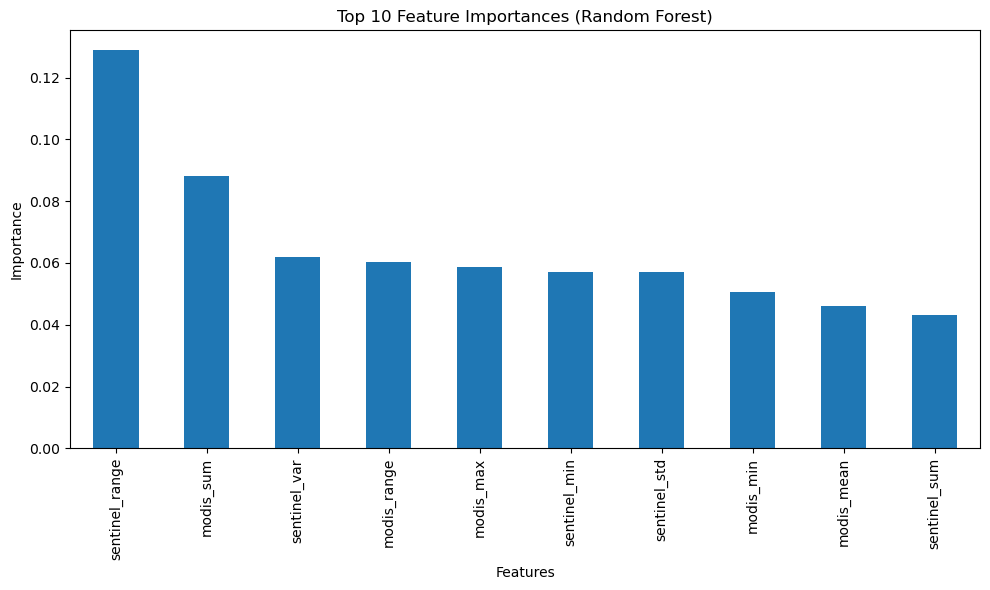

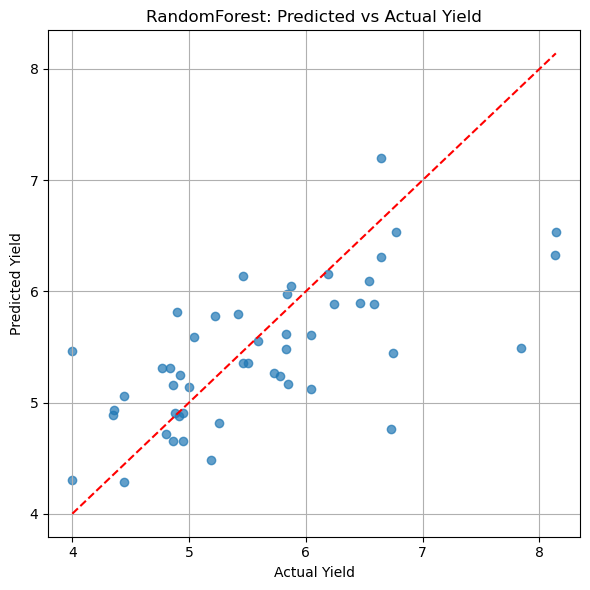

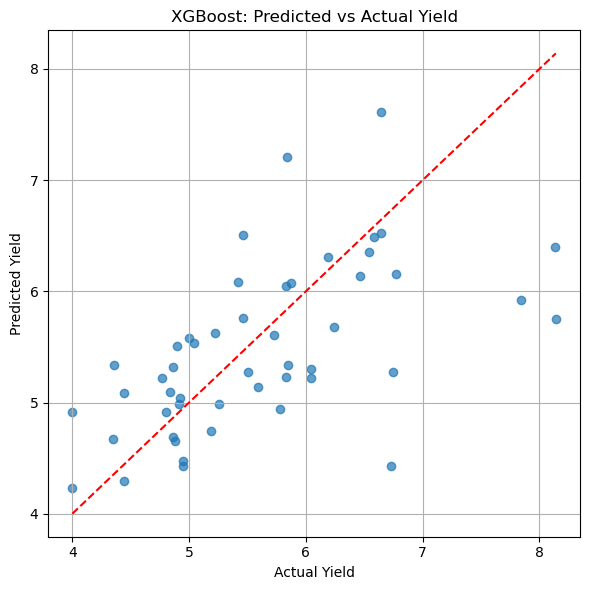

In [39]:
#calculate importance of each feature, print results, visualize results [input results_df]

feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

#print results

print("Model Performance (RMSE and CV RMSE):")
print(results_df)
print("\nTop 10 Most Important Features (Random Forest):")
print(feature_importances.head(10))

#visualize results

# --- Feature Importance Bar Plot ---
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# --- Predicted vs Actual Yield Scatter Plots ---
for name, (y_true, y_pred) in predictions.items():
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Perfect prediction line
    plt.title(f'{name}: Predicted vs Actual Yield')
    plt.xlabel('Actual Yield')
    plt.ylabel('Predicted Yield')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [40]:
#percent accuracy metric

"""
With both modis and sentinel --->
RandomForest - MAPE: 11.49%, Approx. Accuracy: 88.51%
XGBoost - MAPE: 12.88%, Approx. Accuracy: 87.12%

With only sentinel --->
RandomForest - MAPE: 9.41%, Approx. Accuracy: 90.59%
XGBoost - MAPE: 10.37%, Approx. Accuracy: 89.63%

Note: adding/removing NaN or empty values does not change accuracy (skew, kurtosis, quartile data are all NaN/empty)
"""

def mean_absolute_percentage_error(y_true, y_pred):
    """Compute MAPE, ignoring zero values to avoid division by zero."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

for name, (y_true, y_pred) in predictions.items():
    mape = mean_absolute_percentage_error(y_true, y_pred)
    accuracy = 100 - mape
    print(f"{name} - MAPE: {mape:.2f}%, Approx. Accuracy: {accuracy:.2f}%")


RandomForest - MAPE: 9.41%, Approx. Accuracy: 90.59%
XGBoost - MAPE: 10.37%, Approx. Accuracy: 89.63%
